#Parameter Efficient Fine-Tuning with Pytorch



## Installing and Importing libraries

In [ ]:
#@title Imports
import sys
import re
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
import transformers
from torch.utils.data import DataLoader

from accelerate import Accelerator
from transformers import AdamW, AutoModelForSequenceClassification, get_scheduler
from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoModelForCausalLM, TextDataset, DataCollatorForLanguageModeling

import datasets
from datasets import load_dataset, load_metric

from transformers import AutoTokenizer, GPT2LMHeadModel

## Data pre-processing

One of the concerns of fine-tuning pre-trained model was the computational cost. My jupyter notebook was constantly crashing and it was running out of memory. Even if I dealt with these problems by adjusting the batch size to smaller number and decreasing the number of epochs, the training time was very long, around 8 hours.

As a result, I investigated more efficient ways to fine tune DailoGPT models that could lead to better performance by not overfitting to the dataset.

In [7]:

tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small", truncation = True, max_length = 1024, padding_side = 'left')
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-small")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

## Dataset quality concerns

In the previous assignment, I have used my telegram chat dataset. However, I believe there were some dataset quality concerns, such as, misspelling or not having enough context for the texts, meaninig they are just fragmantation of conversations. Thus, I have decided to use a dataset from my most favorite TV series, Doctor Who, to create a chatbot that resembles the main characters behavior.

In [26]:
#@title Data
doctor_data = pd.read_csv('all-scripts.csv')
doctor_data = doctor_data[(doctor_data['type'] == 'talk')]
doctor_data = pd.DataFrame(doctor_data)
doctor_data.head()

,idx,text,type,details,episodeid,doctorid
2,2,Where's mother?,talk,REMUS,21-7,6
3,3,She's busy.,talk,SYLVEST,21-7,6
4,4,Does that mean she isn't talking to us?,talk,ROMULUS,21-7,6
5,5,"No, she's just busy.",talk,SYLVEST,21-7,6
6,6,We would like to see her.,talk,BOTH,21-7,6


In [42]:
print(f' Total number of samples: {len(doctor_data)}')

 Total number of samples: 245632


In [28]:
new_data_train = ''
new_data_test = ''
for i in range(len(doctor_data)-1):

    message, next_message = doctor_data.iloc[i], doctor_data.iloc[i+1]
    if message['text'] == '' or type(message['text']) != str:
        continue
    if next_message['text'] == '' or type(next_message['text']) != str:
        continue

    if doctor_data.iloc[i]['details'] == 'DOCTOR':
        user = 1
    else:
        user = 0

    message_text = re.sub(r"\n", ". ", message['text'])

    if i < len(doctor_data)*0.9:
        new_data_train += f"|{user}|{message_text}{tokenizer.eos_token}" + "\n"
    else:
        new_data_test += f"|{user}|{message_text}{tokenizer.eos_token}" + "\n"

In [29]:
with open("training_dataset.txt", "w", encoding='utf-8') as myfile:
    myfile.write(new_data_train)

with open("test_dataset.txt", "w", encoding='utf-8') as myfile:
    myfile.write(new_data_test)

The data structure is


**|user|  'text'  {eos}**


User is 1 when the text is said by the doctor and 0 for everyone else. This way the model can distinquish between characters of the movie.

In [34]:
# Define the number of lines to read
num_lines_to_read = 10

# Open the file and read the first few lines
with open("training_dataset.txt", "r", encoding='utf-8') as myfile:
    for _ in range(num_lines_to_read):
        line = myfile.readline()
        print(line)

|0| Where's mother?<|endoftext|>

|0| She's busy.<|endoftext|>

|0| Does that mean she isn't talking to us?<|endoftext|>

|0| No, she's just busy.<|endoftext|>

|0| We would like to see her.<|endoftext|>

|0| She isn't here.<|endoftext|>

|0| She's gone out without saying goodbye?<|endoftext|>

|0| Well, yes.<|endoftext|>

|0| I suppose you're going out as well.<|endoftext|>

|0| In a few minutes.<|endoftext|>



## Model Construnction



In [44]:
#@title DailoGPT
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Linear(
            (base_layer): Conv1D()
            (ia3_l): ParameterDict(  (defualt): Parameter containing: [torch.cuda.FloatTensor of size 2304x1 (cuda:0)])
          )
          (c_proj): Linear(
            (base_layer): Conv1D()
            (ia3_l): ParameterDict(  (defualt): Parameter containing: [torch.cuda.FloatTensor of size 768x1 (cuda:0)])
          )
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Linear(
            (base_layer): Conv1D()
            (ia3_l): Paramete

From the codecell output above, we can observe the architecture of GPT2 model. This could be illustrated as follows:





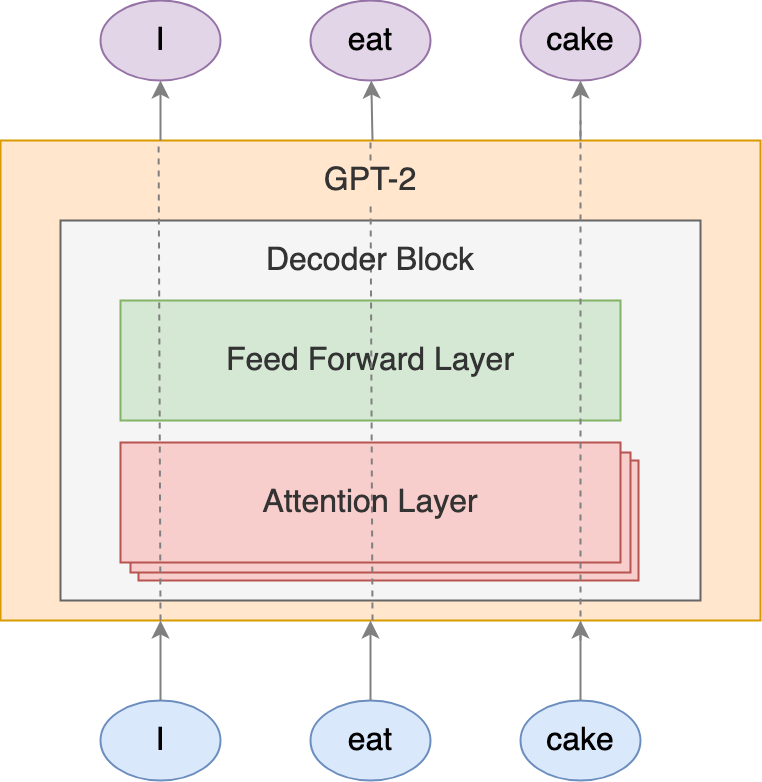

The model imported by AutoModelForCausalLM.from_pretrained command is the decoder block of GPT2. It includes Attention layer and Feed forward layer.

The feed forward layer can be seen as mlp and it consists of two linear transformation layers with activition function inbetween. We can see from the model architecture above that c_fc, c_proj are the two linear transformation layers and act (NewGeluActivation) is the activation function.

We can further dive into the attention layer which consists of transformers.

Transformers

The model starts with parameters Wpre that have optimized over large texts. When we provide a new dataset, we are telling it to adjust its parameters to better suit this type of data. The objective during fine-tuning is to minimize a loss function that L(W) measures the difference between the predictions and the actual data. To update its parameters, the model uses algorithms like stochastic gradient descent or variants like Adam or AdamW. As a result, we reduce the loss with Wnew=Wpre-η▽L(Wpre), where η is the learning rate and ▽L(Wpre) is the gradient of the loss function. Lastly, backpropagation is used for efficient computation for the gradients. As a result, we get Wnew where the function f(x; Wnew) is now better at mapping inputs to outputs that align with our desired patterns. Now let’s dive into how Wpre get trained in the first place:

Tokenization and Encoding

Let’s say we want the transformer model to process a new sentence like “I am the doctor, and I save people”. Since it can’t process raw text, we have to assign numerical values. In our case, the tokenizer breaks the sentence into tokens where each token is mapped to a unique integer based on the model’s vocabulary. Next, we move on to the embedding part, converting each integer token into a high-dimensional vector. Let’s say the embedding of ti (token) is Eword[ti].


Positional Encoding

It is essential to preserve information about the positions. Hence, we introduce positional encoding, which involves creating a vector for each position in the sequence. We use the following formula for this:

PE(pos,2i)=sin(pos/10000**(2i/d))

PE(pos,2i+1)=cos(pos/10000**(2i/d)) where d is dimensionality of the embeddings, i is the dimension index within the positional encoding vector and pos is the position of the token in the sequence. Let’s look at an example for our “I” at position 0 with d=4:

PE(0,0)=sin(0/10000**(20/4))=0

PE(0,1)=sin(0/10000**(21/4))=1

PE(0,2)=sin(0/10000**(22/4))=0

PE(0,3)=sin(0/10000**(23/4))=1.

As a result, we get [0,1,0,1] for position 0. Just like this, we calculate positional encoding for each words to obtain PEword so now we can get the combined representation as Eword+PEword, ready to pass it through the Transformer layers.


Passing through Transformers Layers




Self-attention Mechanism is the core component of the transformers where it calculates attention score between a specific word and all other tokens in the sentence. It calculates how much attention should be given to each word for processing the current word. This similarity scoring extends to unlimited length of reference, which was not the case for previous models.  Mathematically, the attention score between two tokens are computed as A(Q,K,V)=softmax(QK^T/sqrt(dk)) where Q,K,V are queries, keys, and values matrices derived from the input embeddings, and dk is the scaling factor. The query is a vector representation of a word for calculating the attention weight concerning other words. For this, the key vector of the other word is attended. Lastly, the value vectors contain information that will be aggregated based on the attention scores derived from these two. As a result, we calculate the weighted sum of all tokens’ embeddings in the sentence. This further fed into feed-forward neural networks, producing a transformed representation of each token. Pay attention that we have abstracted away the stacking process where layers of parallel processing take place on each passing. For instance, the last step is repeated for each layer in the transformer where their own parameters capture different aspects of the sentence. The output of the final transformer layer is a set of vectors representing each token.



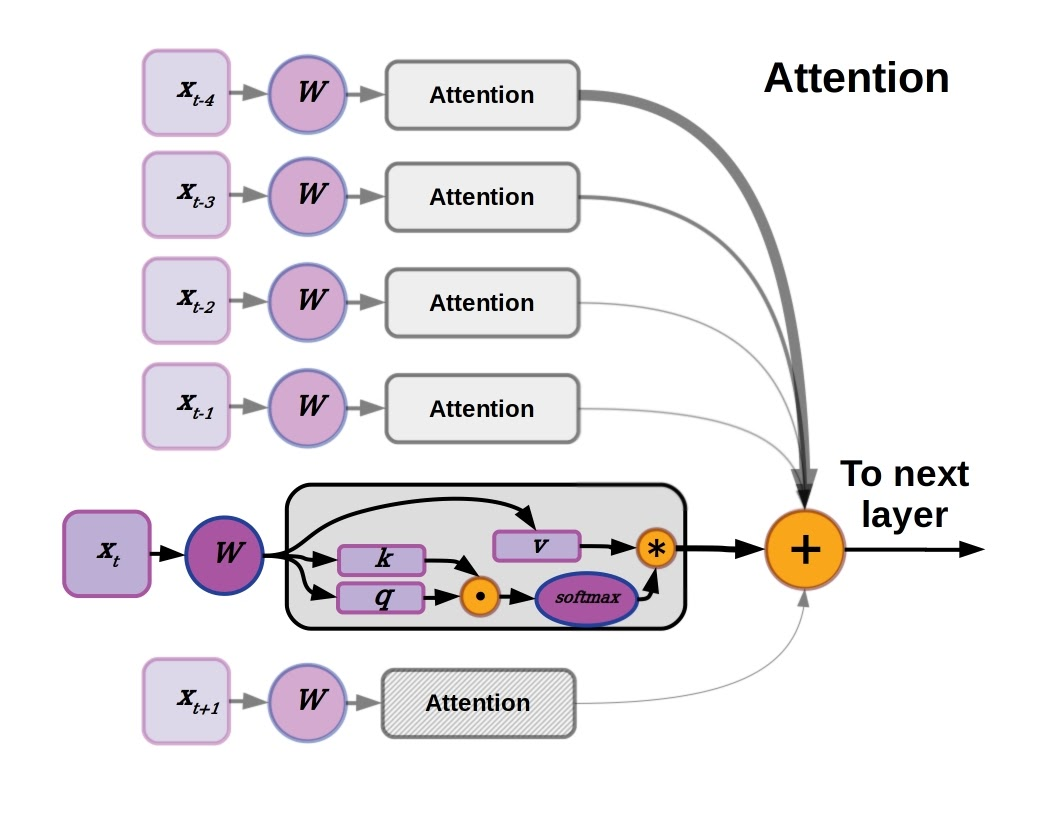






In [13]:
def number_of_trainable_params(model):
  model_parameters = filter(lambda p: p.requires_grad, model.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  return params

From this architecture of GPT2 with 12 multi-head attention, we get 124439808 trainable parameters. However, training all of this parameters might lead to overfitting and it is computationally costly as we discussed above. Thus, we will continue to Parameter Efficient Fine-Tuning (PEFT).

In [14]:
print(f'Number of trainable parameters: {number_of_trainable_params(model)}')

Number of trainable parameters: 124439808


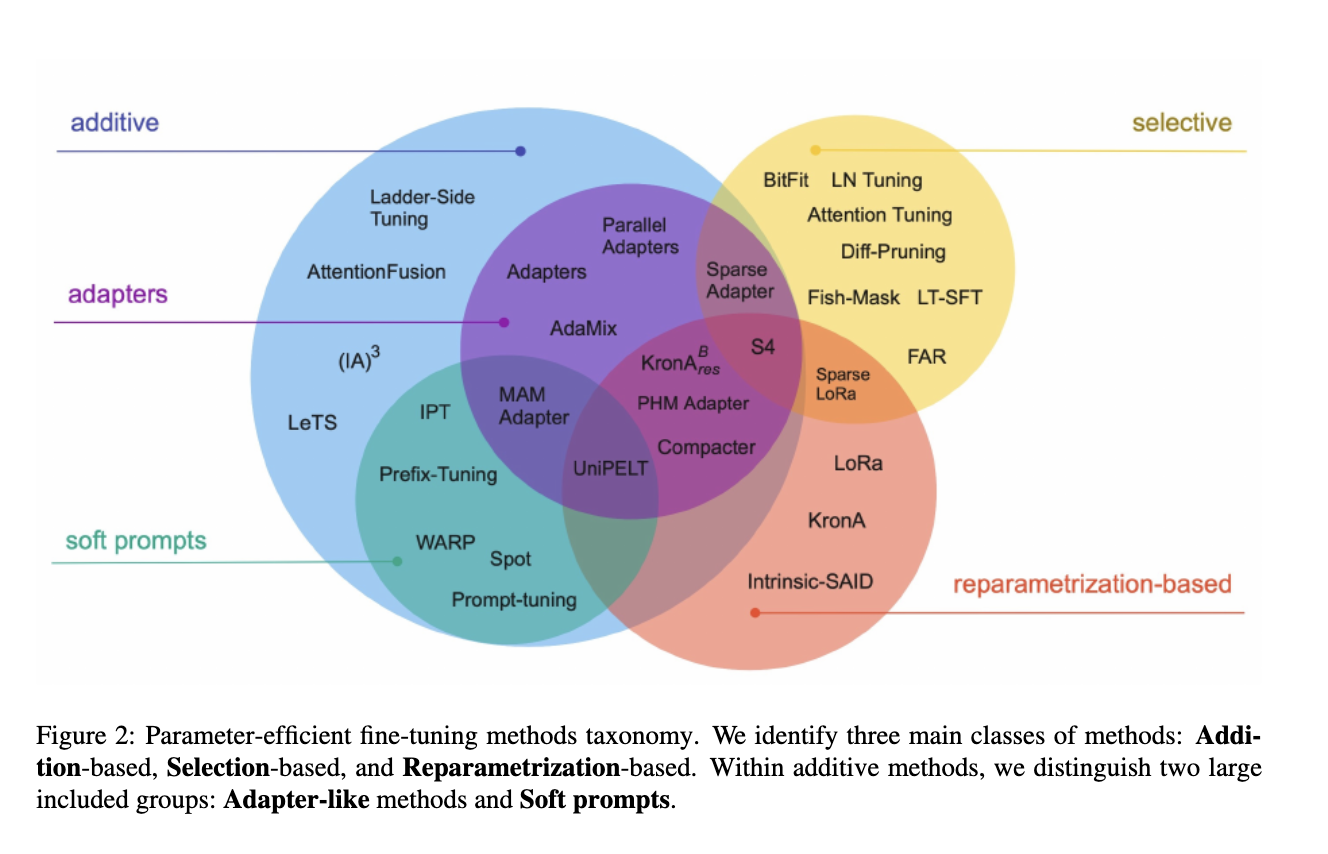

There are many different methods of PEFT as we can see from the diagram. In this assignment, I will compare only two methods which is Addition-based and Selection-based.

Addition-based means that we add extra layer inbetween the pre-trained model's archeticture and only train the parameters of those extra layers we added. This allows us to have less parameters and fine-tune efficiently while keeping the parameters of the original model.

Selection-based is a method to freeze some parameters of the original model and train the rest of the parameters only. For example, we can freeze all the layers of GPT2 model, except the lm_head layer. This means we would only train the lm_head parameters.

## IA3 Model

For the Addition-based models, we are specifically implementing IA3 method which is to add extra layers to specific location of the original GPT2 model. In this implementation, I am injecting this extra layers into 'attn.c_proj','attn.c_attn','mlp.c_proj', 'mlp.c_fc' of the original GPT2 model.

**Attention Layers**

Q,K,V=Linear(X), where X is the input embedding. IA3 modifies this layer by adding A low-rank matrix. Then, we can rewrite the formulation as following

Q,K,V=Linear(X) + A⋅X and we only train the parameters of the A matrix


**Feed Forward Layer**

In the Feed forward layers, we can similarly define the mathematical formulations.

Y=Activation(Linear(X)) and by modifying IA3, we get


Y=Activation(Linear(X)+A⋅X), where A is different low rank matrix which is trainable.

In [15]:
from peft import IA3Model, IA3Config

config = IA3Config(
    peft_type="IA3",
    task_type="CAUSAL_LM",
    target_modules=['attn.c_proj','attn.c_attn','mlp.c_proj', 'mlp.c_fc'],
    feedforward_modules=['mlp.c_proj',  'mlp.c_fc'],
    fan_in_fan_out = True
)

ia3_model = IA3Model(model, config, 'defualt')


print(f'Number of trainable parameters: {number_of_trainable_params(ia3_model)}')

Number of trainable parameters: 82944


With IA3 method for parameter efficient fine tuning, we drastically decreased the number of trainable parameters from 124,439,808 to 82944 which is around 0.07%.

In [16]:
#@title Model Architecture after IA3 Modification
ia3_model

IA3Model(
  (model): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Linear(
              (base_layer): Conv1D()
              (ia3_l): ParameterDict(  (defualt): Parameter containing: [torch.FloatTensor of size 2304x1])
            )
            (c_proj): Linear(
              (base_layer): Conv1D()
              (ia3_l): ParameterDict(  (defualt): Parameter containing: [torch.FloatTensor of size 768x1])
            )
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Linear(
              (base_layer):

## Training

In [39]:
# Create datasets
train_dataset = TextDataset(tokenizer=tokenizer, file_path="training_dataset.txt", block_size=256)
test_dataset = TextDataset(tokenizer=tokenizer, file_path="test_dataset.txt", block_size=256)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [40]:
training_args = TrainingArguments(
    output_dir='./results',          # Directory for storing outputs
    num_train_epochs=2,              # Number of training epochs
    per_device_train_batch_size=8,   # Batch size per device during training
    per_device_eval_batch_size=8,    # Batch size for evaluation
    warmup_steps=100,                # Number of warmup steps
    weight_decay=0.01,               # Weight decay
    logging_dir='./logs',            # Directory for storing logs
    save_total_limit=1,              # Limit the total amount of checkpoints
    load_best_model_at_end=False,     # Load the best model at the end of training      och
)

# Initialize Trainer
trainer = Trainer(
    model=ia3_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    optimizers=(torch.optim.AdamW(ia3_model.parameters(), lr=3e-5), None)  # Optimizer (and LR scheduler if needed)
)


In [41]:
# Train and evaluate
trainer.train()

Step,Training Loss


TrainOutput(global_step=328, training_loss=12.740724144912347, metrics={'train_runtime': 133.0358, 'train_samples_per_second': 19.664, 'train_steps_per_second': 2.466, 'total_flos': 342103261446144.0, 'train_loss': 12.740724144912347, 'epoch': 2.0})

In [43]:
#@title Text

chat_history_ids = torch.zeros((1, 0), dtype=torch.int).to(ia3_model.device)

while True:

    next_who = input("Who's phrase?\t")

    if next_who == "H":
        input_user = input("===> Human: ")

        new_user_input_ids = tokenizer.encode(f"|0|" \
                                              + input_user + tokenizer.eos_token, return_tensors="pt").to(ia3_model.device)

        chat_history_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1)

    if next_who == "G":


        new_user_input_ids = tokenizer.encode(f"|1|", return_tensors="pt").to(ia3_model.device)

        chat_history_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1)


        input_len = chat_history_ids.shape[-1]

        chat_history_ids = ia3_model.generate(
            chat_history_ids,
            num_return_sequences= 1,
            max_length=512,
            no_repeat_ngram_size=3,
            do_sample=True,
            top_k=20,
            top_p=0.9,
            temperature = 0.6,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id,
        )

        print(f"===> Billy:  {tokenizer.decode(chat_history_ids[:, input_len:][0], skip_special_tokens=True)}")

Who's phrase?	H
===> Human: Hello!
Who's phrase?	G
===> Billy:  
Who's phrase?	H
===> Human: How are you doing ?
Who's phrase?	G
===> Billy:  18 intercourse intercourse
Who's phrase?	H
===> Human: What is the biggest planet in the solar system ?
Who's phrase?	G
===> Billy:  2026202020 20202040 202040
Who's phrase?	H
===> Human: What did you have for dinner ?
Who's phrase?	G
===> Billy:   Why did you occasian!


KeyboardInterrupt: Interrupted by user